# Christie Woodside HW6 World Bank LinRegr

In [75]:
import pandas as pd
import numpy as np

owid_data = pd.read_csv('owid-energy-data.csv')
#print(owid_data.head())
owid_filtered = owid_data[['iso_code', 'year','energy_per_capita']].dropna()
#print(owid_filtered.head(35))

In [76]:
import wbdata
import wbgapi as wb

indicators = {
    'EN.ATM.CO2E.PC': 'CO2Emissions',
    'NY.GDP.PCAP.PP.KD': 'GDPpercapita',
    'GB.XPD.RSDV.GD.ZS': 'Research',
    'NE.TRD.GNFS.ZS': 'Trade',
    'EG.FEC.RNEW.ZS': 'RenewableEnergy',
    'NV.MNF.TECH.ZS.UN': 'MedAndHighTechInd',
    'SP.URB.TOTL.IN.ZS': 'Urban',
    'EG.USE.PCAP.KG.OE': 'EnergyUse'  # Energy Use variable to be replaced
}

start_year = 1990
end_year = 2023
df = wb.data.DataFrame(indicators.keys(), time=range(start_year, end_year + 1), labels=True)
#print(df.head())


In [109]:
df = df.reset_index()
df_melted = df.melt(id_vars=['economy', 'series', 'Country', 'Series'], var_name='Year', value_name='Value')
df_melted['Year'] = df_melted['Year'].str.replace('YR', '')
print(df_melted.head())

  economy          series                Country  \
0     ZWE  EN.ATM.CO2E.PC               Zimbabwe   
1     ZMB  EN.ATM.CO2E.PC                 Zambia   
2     YEM  EN.ATM.CO2E.PC            Yemen, Rep.   
3     PSE  EN.ATM.CO2E.PC     West Bank and Gaza   
4     VIR  EN.ATM.CO2E.PC  Virgin Islands (U.S.)   

                                   Series   Year  Value  
0  CO2 emissions (metric tons per capita)  index    0.0  
1  CO2 emissions (metric tons per capita)  index    1.0  
2  CO2 emissions (metric tons per capita)  index    2.0  
3  CO2 emissions (metric tons per capita)  index    3.0  
4  CO2 emissions (metric tons per capita)  index    4.0  


In [126]:
df_pivot = df_melted.pivot_table(index=['economy', 'Country', 'Year'],
columns='series', values='Value')
df_pivot = df_pivot.rename(columns=indicators)
df_pivot = df_pivot.reset_index()
# print(df_pivot.head())
# print(df_pivot.columns)



# print("Unique values in df_pivot['Year']:")
# print(df_pivot['Year'].unique())
df_pivot['Year'] = pd.to_numeric(df_pivot['Year'], errors='coerce')
df_pivot = df_pivot.dropna(subset=['Year'])
df_pivot['Year'] = df_pivot['Year'].astype(int)


# print("Unique values in owid_filtered['year']:")
# print(owid_filtered['year'].unique())
owid_filtered['year'] = pd.to_numeric(owid_filtered['year'], errors='coerce')

# print("Data types after conversion:")
# print(df_pivot.dtypes)
# print(owid_filtered.dtypes)

final_data = pd.merge(df_pivot, owid_filtered, left_on=['economy', 'Year'], right_on=['iso_code', 'year'], how='left')
final_data = final_data.drop(columns=['EnergyUse'])  # Drop old Energy Use column
final_data = final_data.rename(columns={'energy_per_capita': 'energy_per_capita'})  # Rename new column

print(final_data.head(15))


   economy Country  Year  RenewableEnergy  CO2Emissions  Research       Trade  \
0      ABW   Aruba  1990              0.3           NaN       NaN         NaN   
1      ABW   Aruba  1991              0.2           NaN       NaN         NaN   
2      ABW   Aruba  1992              0.2           NaN       NaN         NaN   
3      ABW   Aruba  1993              0.2           NaN       NaN         NaN   
4      ABW   Aruba  1994              0.2           NaN       NaN         NaN   
5      ABW   Aruba  1995              0.2           NaN       NaN  171.362098   
6      ABW   Aruba  1996              0.2           NaN       NaN  175.344130   
7      ABW   Aruba  1997              0.2           NaN       NaN  168.781911   
8      ABW   Aruba  1998              0.2           NaN       NaN  163.267360   
9      ABW   Aruba  1999              0.2           NaN       NaN  164.559014   
10     ABW   Aruba  2000              0.2           NaN       NaN  145.072880   
11     ABW   Aruba  2001    

In [122]:
#final_data.to_csv('reshaped_world_bank_data_1990_2023.csv', index=False)
duplicates = owid_filtered[owid_filtered.duplicated(subset=['iso_code'], keep=False)]
print(duplicates)    #because techniclaly there will always be duplicates because of the years so not helpful but wanted to see

      iso_code  year  energy_per_capita
104        AFG  1980            623.929
105        AFG  1981            786.837
106        AFG  1982            926.651
107        AFG  1983           1149.196
108        AFG  1984           1121.573
...        ...   ...                ...
21805      ZWE  2017           3068.011
21806      ZWE  2018           3441.986
21807      ZWE  2019           3003.655
21808      ZWE  2020           2680.132
21809      ZWE  2021           2635.154

[9919 rows x 3 columns]


### Perform the regression using all continuous variables in the dataset, with CO2 emissions as the dependent variable. Don't forget to log-transform any skewed variables, as per our previous discussion.

In [127]:
print(final_data.columns)
#continouous variables
'''RenewableEnergy - Percentage or ratio of renewable energy.
CO2Emissions - CO2 emissions per capita. (but this is the dependent variable)
Research - Research and development expenditure (likely as a percentage of GDP).
Trade - Trade as a percentage of GDP.
MedAndHighTechInd - Percentage of manufacturing in medium and high-tech industries.
GDPpercapita - GDP per capita (adjusted for purchasing power parity).
Urban - Urban population as a percentage of the total.
energy_per_capita - Energy consumption per capita (replacing the old EnergyUse variable). '''

Index(['economy', 'Country', 'Year', 'RenewableEnergy', 'CO2Emissions',
       'Research', 'Trade', 'MedAndHighTechInd', 'GDPpercapita', 'Urban',
       'iso_code', 'year', 'energy_per_capita'],
      dtype='object')


'RenewableEnergy - Percentage or ratio of renewable energy.\nCO2Emissions - CO2 emissions per capita. (but this is the dependent variable)\nResearch - Research and development expenditure (likely as a percentage of GDP).\nTrade - Trade as a percentage of GDP.\nMedAndHighTechInd - Percentage of manufacturing in medium and high-tech industries.\nGDPpercapita - GDP per capita (adjusted for purchasing power parity).\nUrban - Urban population as a percentage of the total.\nenergy_per_capita - Energy consumption per capita (replacing the old EnergyUse variable). '

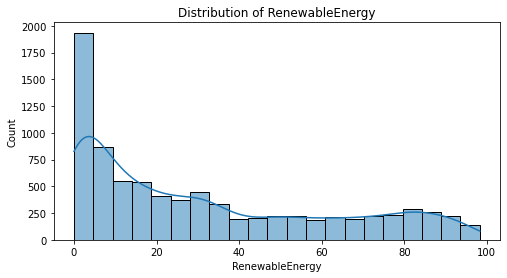

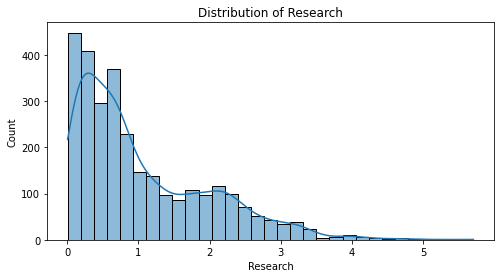

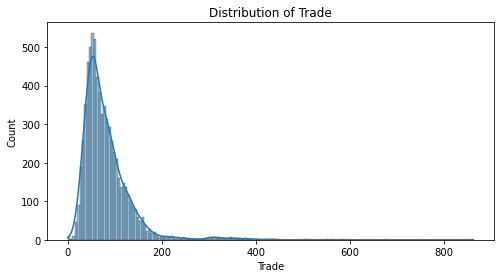

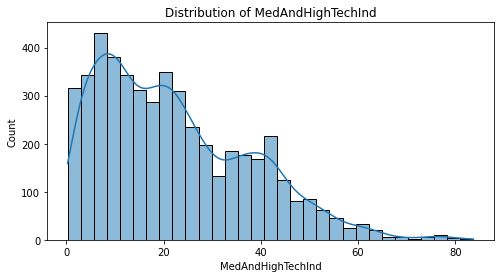

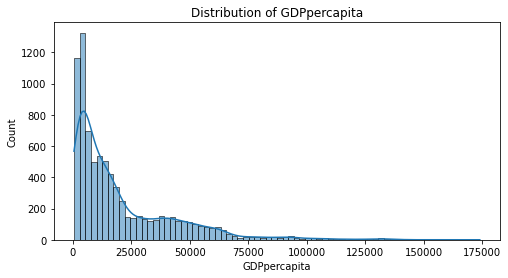

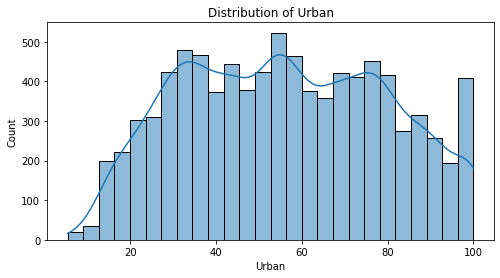

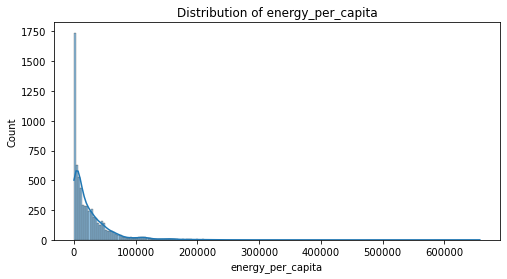

RenewableEnergy      0.731797
Research             1.182180
Trade                3.360217
MedAndHighTechInd    0.770146
GDPpercapita         1.949754
Urban                0.077830
energy_per_capita    5.225665
dtype: float64


In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of continuous variables
'''originally had in CO2 so I could see what it looks like as a plot, but ti was removed from the list'''
continuous_vars = ['RenewableEnergy','Research', 'Trade', 
                   'MedAndHighTechInd', 'GDPpercapita', 'Urban', 'energy_per_capita']

# Plot histograms for each continuous variable
for var in continuous_vars:
    plt.figure(figsize=(8,4))
    #plt.subplot(2, 2, 1)
    sns.histplot(data=final_data, x=var, kde=True)
    plt.title(f'Distribution of {var}')
    plt.show()

skewness = final_data[continuous_vars].skew()
print(skewness)

research, trade, GDPpercapita, and energy per capita are all skewed because they are greater than 1. These will need to be log transformed

In [129]:
import statsmodels.api as sm

# # Check for missing data in each column
# print(final_data.isnull().sum())
# # Check for missing data in each row
# print(final_data.isnull().sum(axis=1))

# Drop rows with missing CO2Emissions (since it's your dependent variable)
final_data = final_data.dropna(subset=['CO2Emissions'])
# Optionally drop rows with too many missing independent variables (if needed)
final_data = final_data.dropna(thresh=6)  # Keep rows with at least 6 non-NaN values


# Log-transform the skewed variables
final_data['log_Research'] = np.log(final_data['Research'] + 1)
final_data['log_Trade'] = np.log(final_data['Trade'] + 1)
final_data['log_GDPpercapita'] = np.log(final_data['GDPpercapita'] + 1)
final_data['log_energy_per_capita'] = np.log(final_data['energy_per_capita'] + 1)
final_data['log_MedAndHighTechInd'] = np.log(final_data['MedAndHighTechInd'] + 1)
#final_data['log_CO2Emissions'] = np.log(final_data['CO2Emissions'] + 1)

X = final_data[['RenewableEnergy', 'log_MedAndHighTechInd', 'Urban',
                'log_Research', 'log_Trade', 'log_GDPpercapita', 'log_energy_per_capita']]
# y = final_data['log_CO2Emissions']
y = final_data['CO2Emissions']

#print(final_data.head())
# Drop rows with missing values
X = X.dropna()
y = y[X.index]
# Add a constant to the independent variables (for the intercept)
X = sm.add_constant(X)
# Perform the regression
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           CO2Emissions   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     362.2
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:32:45   Log-Likelihood:                -5054.2
No. Observations:                1939   AIC:                         1.012e+04
Df Residuals:                    1931   BIC:                         1.017e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -25.17

#### The R value (correlation coefficient) is very low meaning there is a weak relationship between the independent and dependent variables

## Ensure that all relevant diagnostic plots are included.

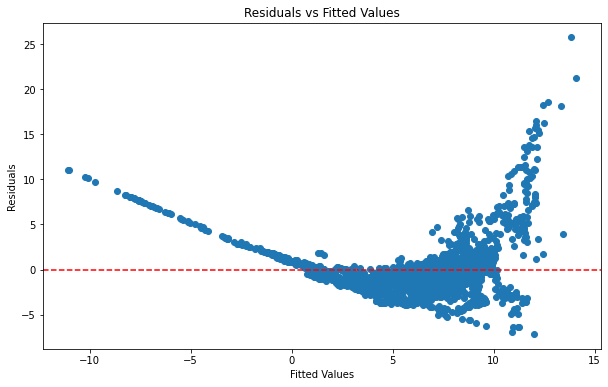

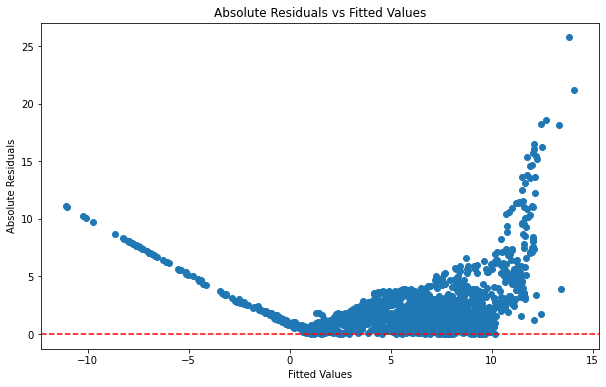

In [130]:
fitted_values = model.fittedvalues
residuals = model.resid


plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, abs(residuals))
plt.axhline(0, color='red', linestyle='--')
plt.title('Absolute Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Absolute Residuals')
plt.show()

So for the graph residuals vs fitted values, there appears to be a defined line shooting up from 0 to the left corner of the graph and it could be also argued that there is a curve in the data forming almost a U or V shape. 

It suggests that the relationships between the dependent and independent variables are non linear. This graph is all independent against one dependent, so one of the independent variables could be throwing off the data and display this distribution. The linear line on the left side of the graph could also be outliers from the data where, again, one or two of the independent variables are throwing off the distribution and thus causing the shape. A non-linear model would best describe the data.

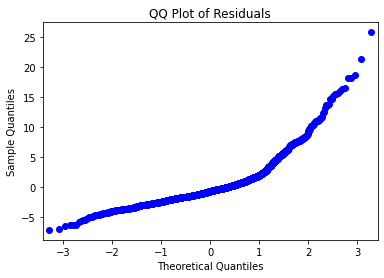

In [131]:
# QQ plot of the residuals
sm.qqplot(residuals)
plt.title('QQ Plot of Residuals')
plt.show()

The plot follows a loose straight line, but there are some outliers on the top right corner and the bottom left corner. Its not a perfect straight line, but isn't making an S curve or anything else super weird. This is indicating that residuals have non-normal tails. The heavy tails suggest outliers with multiple data points straying from the line. These points do not follow the normal distribution assumption. 

### Incorporate country indicators into the model and assess whether this improves the model's performance.

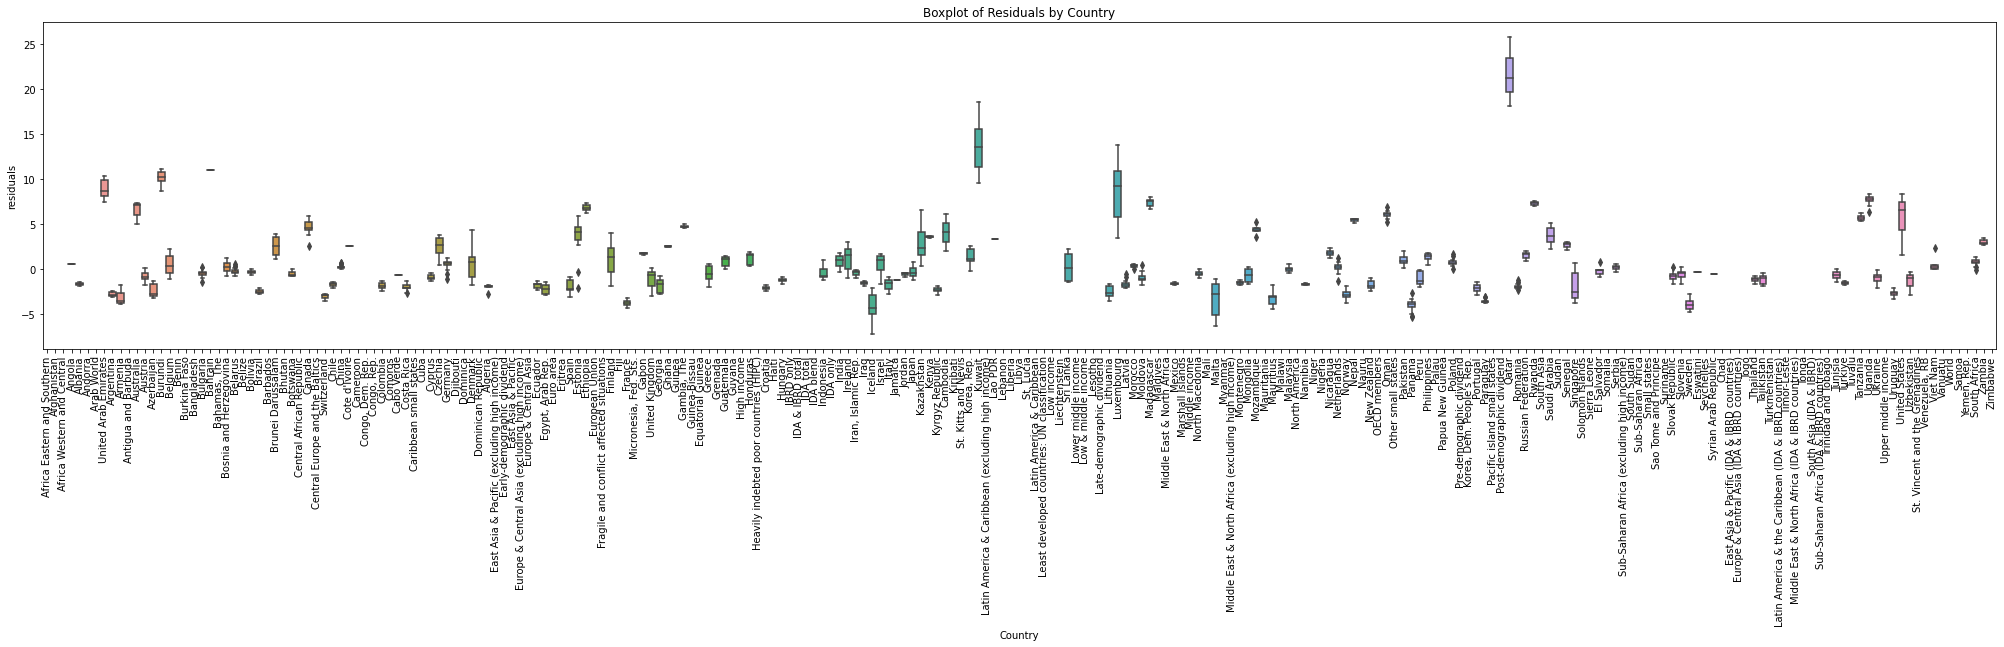

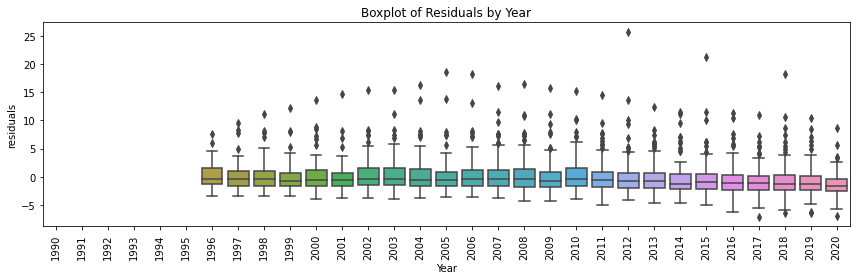

In [132]:
''' taken form profs notes to see hwo it worked'''

import matplotlib.pyplot as plt
import seaborn as sns
# Assuming residuals are from the fitted model and df_filtered contains 'Country' and 'Year'

final_data['residuals'] = residuals # Add residuals to the DataFrame

plt.figure(figsize=(35, 6))
sns.boxplot(x='Country', y='residuals', data=final_data)
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.title('Boxplot of Residuals by Country')
#plt.tight_layout()
plt.show()

# Boxplot of residuals by Year
plt.figure(figsize=(12, 4))
sns.boxplot(x='Year', y='residuals', data=final_data)
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.title('Boxplot of Residuals by Year')
plt.tight_layout()

In [133]:

'''The data should already be log transformed from above, but doing again
(it honestly changed nothing about the graph at all)'''

final_data['log_Research'] = np.log(final_data['Research'] + 1)
final_data['log_Trade'] = np.log(final_data['Trade'] + 1)
final_data['log_GDPpercapita'] = np.log(final_data['GDPpercapita'] + 1)
final_data['log_energy_per_capita'] = np.log(final_data['energy_per_capita'] + 1)
#final_data['log_CO2Emissions'] = np.log(final_data['CO2Emissions'] + 1)

df_with_dummies = pd.get_dummies(final_data, columns=['Country'], drop_first=True)

# Define the dependent and independent variables
X_with_dummies = df_with_dummies[['RenewableEnergy', 'MedAndHighTechInd', 'Urban', 
                                  'log_Research', 'log_Trade', 'log_GDPpercapita', 
                                  'log_energy_per_capita'] + [col for col in df_with_dummies.columns if 'Country_' in col]]

X_with_dummies['RenewableEnergy'].fillna(X_with_dummies['RenewableEnergy'].mean(), inplace=True)
X_with_dummies['MedAndHighTechInd'].fillna(X_with_dummies['MedAndHighTechInd'].mean(), inplace=True)
X_with_dummies['log_Research'].fillna(X_with_dummies['log_Research'].mean(), inplace=True)
X_with_dummies['log_Trade'].fillna(X_with_dummies['log_Trade'].mean(), inplace=True)
X_with_dummies['log_GDPpercapita'].fillna(X_with_dummies['log_GDPpercapita'].mean(), inplace=True)
X_with_dummies['log_energy_per_capita'].fillna(X_with_dummies['log_energy_per_capita'].mean(), inplace=True)

# if 'log_CO2Emissions' not in df_with_dummies.columns:
#     df_with_dummies['log_CO2Emissions'] = np.log(df_with_dummies['CO2Emissions'].replace(0, np.nan))
#y_with_dummies = df_with_dummies['log_CO2Emissions']

y_with_dummies = df_with_dummies['CO2Emissions']
y_with_dummies.fillna(y_with_dummies.mean(), inplace=True)

X_with_dummies_clean = X_with_dummies.dropna()
y_with_dummies_clean = y_with_dummies[X_with_dummies_clean.index]



# # Re-check for NaNs and infinite values across all columns
# print("NaN values in X_with_dummies after stricter check:")
# print(X_with_dummies.isna().sum().sum())  # Sum all NaN values across the DataFrame

# print("Infinite values in X_with_dummies after stricter check:")
# print(np.isinf(X_with_dummies).sum().sum())  # Sum all infinite values across the DataFrame

# # Identify columns with NaNs or infinite values (if any)
# print("Columns with NaNs:")
# print(X_with_dummies.columns[X_with_dummies.isna().any()])

# print("Columns with infinite values:")
# print(X_with_dummies.columns[np.isinf(X_with_dummies).any()])


y_with_dummies = y_with_dummies.reindex(X_with_dummies.index)
X_with_dummies = sm.add_constant(X_with_dummies)

# # Check for NaNs and infinite values in y_with_dummies
# print("NaN values in y_with_dummies after stricter check:")
# print(y_with_dummies.isna().sum())

# print("Infinite values in y_with_dummies after stricter check:")
# print(np.isinf(y_with_dummies).sum())

# Reindex y_with_dummies to match X_with_dummies
y_with_dummies = y_with_dummies.reindex(X_with_dummies.index)

# # Check if there is a mismatch in index alignment
# print("Index mismatch check between X_with_dummies and y_with_dummies:")
# print(X_with_dummies.index.equals(y_with_dummies.index))

X_with_dummies_clean = X_with_dummies.replace([np.inf, -np.inf], np.nan).dropna()
y_with_dummies_clean = y_with_dummies[X_with_dummies_clean.index]
#print(y_with_dummies_clean)


X_with_dummies = sm.add_constant(X_with_dummies)
model_with_dummies = sm.OLS(y_with_dummies, X_with_dummies).fit()
print(model_with_dummies.summary())



/Users/christiewoodside/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


                            OLS Regression Results                            
Dep. Variable:           CO2Emissions   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     709.4
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:40:36   Log-Likelihood:                -10751.
No. Observations:                7390   AIC:                         2.199e+04
Df Residuals:                    7144   BIC:                         2.369e+04
Df Model:                         245                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

### The R sq did get better once the countries was applied. This shows a much better correlation between the variables

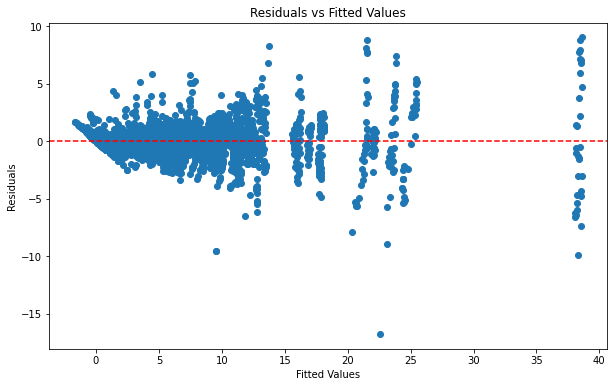

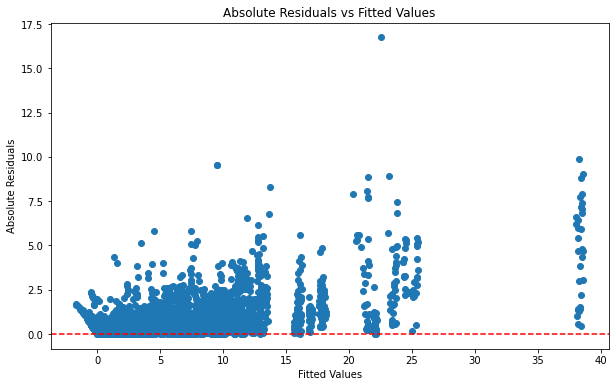

In [134]:
fitted_values = model_with_dummies.fittedvalues
residuals = model_with_dummies.resid


plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, abs(residuals))
plt.axhline(0, color='red', linestyle='--')
plt.title('Absolute Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Absolute Residuals')
plt.show()

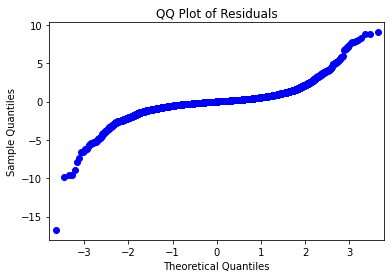

In [120]:
# QQ plot of the residuals
sm.qqplot(residuals)
plt.title('QQ Plot of Residuals')
plt.show()

FIRST residual graphs:    Already there is a huge difference. There is no distinct U trend/pattern and all the points try to cluster at the red line 0. There is however lines popping up from the 0 creating a sort of pattern. This plot could then suggest that the error variances are not equal.

SECOND QQ plot: Interestingly enough though, the line in the QQ plot is not very linear and the tails seem to be even heavier with more outliers. Because it is sort of a curved almost S shape, this indicates that this data may be skewed again. The values have been log transformed, but the data could still be skewed.

## Next, add a linear trend for Year. Does this improve the model fit?

                            OLS Regression Results                            
Dep. Variable:           CO2Emissions   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     737.7
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:54:26   Log-Likelihood:                -10597.
No. Observations:                7390   AIC:                         2.169e+04
Df Residuals:                    7143   BIC:                         2.339e+04
Df Model:                         246                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

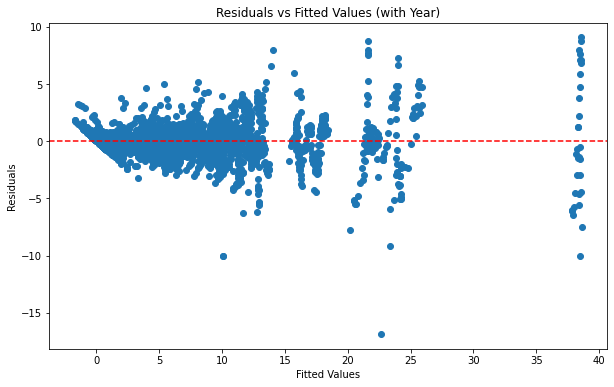

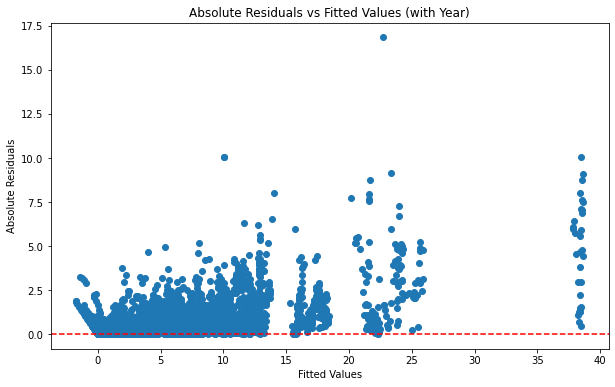

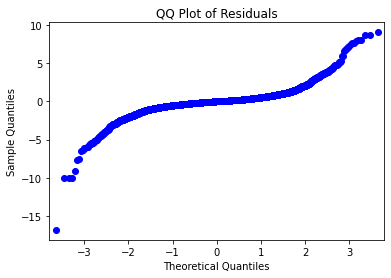

In [136]:
X_with_dummies['Year'] = final_data['Year']

X_with_dummies['Year'].fillna(X_with_dummies['Year'].mean(), inplace=True)

X_with_dummies_clean = sm.add_constant(X_with_dummies)
model_with_year = sm.OLS(y_with_dummies, X_with_dummies_clean).fit()

print(model_with_year.summary())

fitted_values_with_year = model_with_year.fittedvalues
residuals_with_year = model_with_year.resid

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values_with_year, residuals_with_year)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values (with Year)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values_with_year, abs(residuals_with_year))
plt.axhline(0, color='red', linestyle='--')
plt.title('Absolute Residuals vs Fitted Values (with Year)')
plt.xlabel('Fitted Values')
plt.ylabel('Absolute Residuals')
plt.show()

sm.qqplot(residuals_with_year)
plt.title('QQ Plot of Residuals')
plt.show()


The R value improved very slightly from 0.961 to 0.962. There is still these string of data spanningt he plot with some hovering around zero. This could still suggest that the error variances are not equal. The QQ plot is still slightly S curved with soem outliers, implying that the data still may be skewed. The model fit doesn't necassarily improve.

## Finally, instead of linear trend in Year , include year indicators and evaluate whether they enhance the model.

                            OLS Regression Results                            
Dep. Variable:           CO2Emissions   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     242.4
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:25:58   Log-Likelihood:                -19746.
No. Observations:                7390   AIC:                         3.957e+04
Df Residuals:                    7352   BIC:                         3.983e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -21.46

/Users/christiewoodside/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


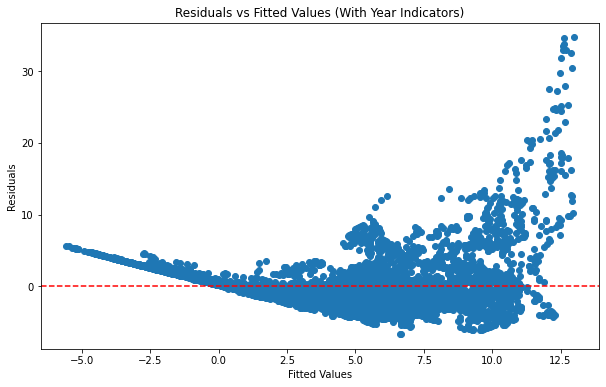

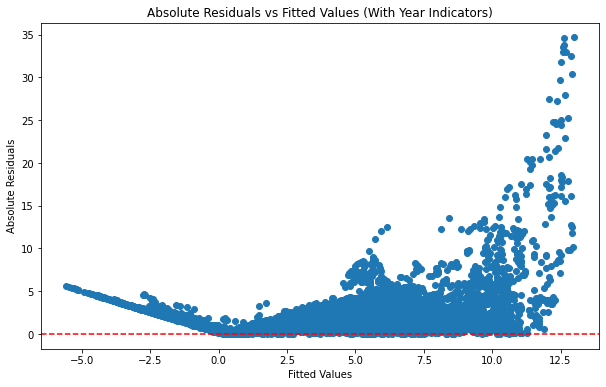

In [139]:
y_with_dummies = df_with_dummies['CO2Emissions']
df_with_dummies = pd.get_dummies(final_data, columns=['Year'], drop_first=True)  # drop_first=True to avoid multicollinearity

X_with_year_dummies = df_with_dummies[['RenewableEnergy', 'MedAndHighTechInd', 'Urban', 
                                       'log_Research', 'log_Trade', 'log_GDPpercapita', 
                                       'log_energy_per_capita'] + 
                                      [col for col in df_with_dummies.columns if 'Country_' in col] + 
                                      [col for col in df_with_dummies.columns if 'Year_' in col]]

X_with_year_dummies['RenewableEnergy'].fillna(X_with_year_dummies['RenewableEnergy'].mean(), inplace=True)
X_with_year_dummies['MedAndHighTechInd'].fillna(X_with_year_dummies['MedAndHighTechInd'].mean(), inplace=True)
X_with_year_dummies['log_Research'].fillna(X_with_year_dummies['log_Research'].mean(), inplace=True)
X_with_year_dummies['log_Trade'].fillna(X_with_year_dummies['log_Trade'].mean(), inplace=True)
X_with_year_dummies['log_GDPpercapita'].fillna(X_with_year_dummies['log_GDPpercapita'].mean(), inplace=True)
X_with_year_dummies['log_energy_per_capita'].fillna(X_with_year_dummies['log_energy_per_capita'].mean(), inplace=True)

X_with_year_dummies_clean = X_with_year_dummies.dropna()
y_with_dummies_clean = y_with_dummies[X_with_year_dummies_clean.index]

X_with_year_dummies_clean = sm.add_constant(X_with_year_dummies_clean)
model_with_year_dummies = sm.OLS(y_with_dummies_clean, X_with_year_dummies_clean).fit()

print(model_with_year_dummies.summary())

fitted_values = model_with_year_dummies.fittedvalues
residuals = model_with_year_dummies.resid

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values (With Year Indicators)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Plot absolute residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, abs(residuals))
plt.axhline(0, color='red', linestyle='--')
plt.title('Absolute Residuals vs Fitted Values (With Year Indicators)')
plt.xlabel('Fitted Values')
plt.ylabel('Absolute Residuals')
plt.show()

No adding year indicators did not make the model fit better. In fact it looks almost like the first graph and shows a U shape. It suggesting again that the relationships between the dependent and independent variables are non linear. A non-linear model would best describe the data.

The R value also decreased from the previosu graphs where we just did a linear trend with year. It jumped from 0.962 to 0.55 indicating that now the correlation between the variables is weaker/non-linear.

### Use AIC and BIC criteria to assess the model fit as well as all relevant diagnostic plots, as we discussed in class.

The AIC and BIC values from the first regression plot are AIC:1.012e+04 and BIC: 1.017e+04. 

The AIC and BIC values from the second regression plot are AIC: 2.199e+04 and BIC:2.369e+04

The AIC and BIC values from the third regression plot are AIC: 2.169e+04 and BIC: 2.339e+04

The AIC and BIC values from the fourth regression plot are AIC: 3.957e+04 BIC: 3.983e+04

Ranked lowest to highest it would be first plot, third plot, second plot, and then fourth plot. The first regression plot would be the best model fit because it has the lowest AIC and BIC values of all the regression plots. The first plot, remember, was the regression on all continous variables in the dataset with CO2 emissions as dependent variable. With so many countries, years, and values all while comparing that to each indicator it will cause a complex model with a lot of moving parts. This is probably also why the plots have not looked very great, but have still had some good correlation coefficients.

It could be helpful to do a regression plot for each indicator and its years against CO2 as the dependent variable to see which one is causing the lack of relationship. These many more plots would help see the trends, correlation, and linearity to CO2 emissions. This however defeats the point and purpose of a multiple linear regression plot and could actually overestimate a single indicator on CO2 emissions. 